# Integrantes
## Andrey Inácio Paulino N°USP : 10818741
## Eduardo Almeida N°USP : 10817027
## Gabriel Victor de Jesus Lima N°USP : 10844226
## Matheus Chaves Silva N°USP : 10838671

In [5]:
#Importações das blibliotecas
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
import random
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

## Exercício 1
### Faça o pré-processamento dos dados e classifique os pacientes de acordo com a variável “target”. Considere os classificadores: Bayesiano paramétrico, Bayesiano não-paramétrico e Naive Bayes. 

In [6]:
#leitura do banco de dados 
data = pd.read_csv('heart.csv')
data = data.dropna(axis='rows') #remove NaN
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)  
nrow, ncol = data.shape
attributes = list(data.columns)
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


### **Começando com o caso Bayesiano paramétrico**

In [7]:
#Normalização dos dados
#Passando para o formato numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]
#Normalizando eles
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

#Definindo um conjunto de teste para treinamento 
p = 0.8#fração de elementos no conjunto de teste 
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

#Matrix para armazenas as probabilidades
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes)

Pc = np.zeros(len(classes)) #Fração de elementos em cada classe
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Pc[i] = len(elements)/len(y_train)
    Z = x_train[elements,:][0]
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [9]:
y_pred = [] #Vetor com classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=int)
print(y_pred)

[0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0
 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]


In [10]:
#Calcula a acurácia
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.8360655737704918


### **Agora o método bayesiano não-paramétrico**

In [11]:
# Seleciona os conjuntos de treinamento e teste
p = 0.8 #fração de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 2
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]

In [12]:
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=int)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.8852459016393442


### **Com o caso de Naive Bayes**

In [13]:
#Seleciona o conjunto de teste e treinamento
p = 0.7#fração de elementos no conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p)

#Função para calcular a verossimilhanca
def likelyhood(y, Z):
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob

#Matriz que armazena o produto da verossimilhanca pela priori
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Z = X_train[elements,:][0]
    for j in np.arange(0,X_test.shape[0]):
        x = X_test[j,:]
        pj = likelyhood(x,Z) #verossimilhanca
        pc = len(elements)/X_train.shape[0] # priori
        P[classes[i]][j] = pj*pc

In [14]:
#Realizando a classificação seguindo a regra de Bayes
y_pred = []
for i in np.arange(0, P.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(P.columns[c])
y_pred = np.array(y_pred, dtype=int)
# calcula a acuracia na classificacao
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7582417582417582


## Exercício 2
### No classificar não-paramétrico, verifique o efeito do hiperparâmetro h na classificação dos dados de diabetes, encontrando seu melhor valor:

In [15]:
#Leitura do banco de dados
data = pd.read_csv('diabetes.csv')
data = data.dropna(axis='rows') #remove NaN
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=int)  
nrow, ncol = data.shape
attributes = list(data.columns)
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [16]:
#Convertendo para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

In [17]:
p = 0.8 #fração de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armazena fração de elementos em cada classe
h = 8
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): #para cada observção no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = []# Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=int)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Acuracia:', score)

Acuracia: 0.6948051948051948


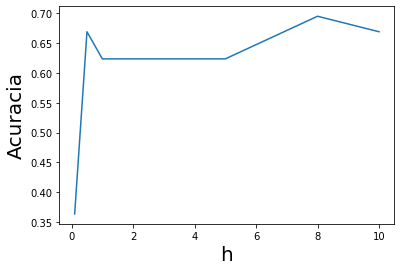

In [18]:
h = [0.1,0.5,1,2,5,8,10]
acuracia = [0.36363636363636365,0.6688311688311688,0.6233766233766234,0.6233766233766234,0.6233766233766234,0.6948051948051948,0.6688311688311688]

plt.plot(h,acuracia)
plt.xlabel('h', fontsize = 20)
plt.ylabel('Acuracia', fontsize = 20)
plt.show()

A partir do gráfico retirado de valores que a acurácia assume a partir de certos valores para h, podemos concluir que quando h=8, ele possuí a melhor acurácia.

## Exercício 3
### Considere o código abaixo para gerar dados artificialmente.
from sklearn import datasets
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap=’viridis’, s=50, alpha=0.7)
plt.show(True)
### Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico, variando o ruído (noise).

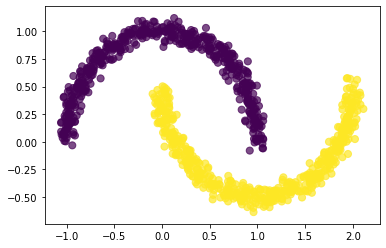

In [19]:
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], cmap='viridis',c=y, s=50, alpha=0.7)
classes=[0,1]
plt.show(True)

In [20]:
#Normalizando os dados
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 4.44089210e-17 -3.69482223e-16]
Desvio Padrao: [1. 1.]


In [21]:
p = 0.8 # fracao de elementos no conjunto de treinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)
# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe

### **Classificador Bayesiano**

In [22]:
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train == classes[i]))
    Pc[i] = len(elements)/len(y_train)
    Z = x_train[elements,:][0]
    m = np.mean(Z, axis = 0)
    cv = np.cov(np.transpose(Z))
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]

In [23]:
y_pred = [] # Vetor com as classes preditas
#np.array(test_x.shape[0], dtype=str)
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=float)
print(y_pred)

[1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1.]


In [24]:
#Calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.855


### **Caso Não Paramétrico**

In [25]:
vh = [0.1, 0.5, 1, 2, 5, 10]
for h in vh:
  for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
  y_pred = [] # Vetor com as classes preditas
  for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
  y_pred = np.array(y_pred, dtype=float)
   # calcula a acuracia
  score = accuracy_score(y_pred, y_test)
  print('Acuracia para H=',h,': ',score)

Acuracia para H= 0.1 :  1.0
Acuracia para H= 0.5 :  0.975
Acuracia para H= 1 :  0.86
Acuracia para H= 2 :  0.84
Acuracia para H= 5 :  0.835
Acuracia para H= 10 :  0.835


### **Classificador Naive Bayes**

In [26]:
model = GaussianNB()
model.fit(x_train, y_train)
#Calcula a acuracia
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.855


## Exercício 4
### Considerando os dados artificiais do exercício anterior, mostre as regiões de separação para os métodos 
### Naive Bayes, k-vizinhos e regressão logística.

### **Naive Bayes**

In [27]:
# Plotting decision regions
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X, y, clf=model, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions')
plt.show()

ModuleNotFoundError: No module named 'mlxtend'

### **k-vizinhos**

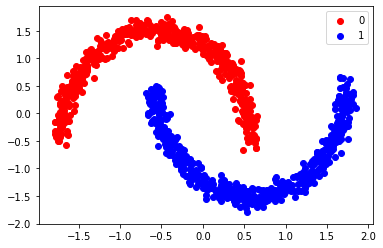

NameError: name 'plot_decision_regions' is not defined

In [28]:
# mostra os dados e colori de acordo com as classes
colors = ['red', 'blue', 'green', 'black']
aux = 0
for c in classes:
    ind = np.where(y == c)
    plt.scatter(X[ind,0][0], X[ind,1][0], color = colors[aux], label = c)
    aux = aux + 1
plt.savefig('knn_ex.eps')
plt.legend()
plt.show()

k=10
#Treinando um classificador
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X, y)
#Plotando regiões de decisão
plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions: k = '+str(k))
#plt.savefig('knn_' + str(k)+'.eps')
plt.show()

### **Regressão Logística**

In [29]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X, y)
#Plotando regiões de decisão
plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
#plt.savefig('logistic-region.eps')
plt.show()

NameError: name 'plot_decision_regions' is not defined

## Exercício 5
### Gere dois conjuntos de pontos em duas dimensões usando o código a seguir:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
n = 500
c = [(1,1), (10,10)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
plt.scatter(X[:,0],X[:,1], c=y)
plt.show(True)
### Compare os classificadores Naive Bayes e Bayesiano Paramétrico variando a separação entre as nuvens de pontos – mantenha a posição de uma classe fixa e mude a posição do centro da outra classe, calculando a distância entre os centros.

In [30]:
#rodar esta célula apenas uma vez
result=[]

In [31]:
n = 500
c = [(1,1), (1,1)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
plt.scatter(X[:,0],X[:,1], c=y)
plt.show(True)

dist=((c[1][0] - c[0][0])**2 + ( c[1][1]-c[0][1])**2)**0.5


data=pd.DataFrame(X,columns=['X_0','X_1'])
data['classe']=y
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)

NameError: name 'make_blobs' is not defined

In [ ]:
#Normalização dos dados
caler = StandardScaler().fit(X)
X = scaler.transform(X)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

In [ ]:
#Criação dos conjuntos de teste e treinamento
p = 0.80# fracao de elementos no conjunto de treinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

### **Classificador bayesiano**

In [ ]:
#matrix to store the probabilities
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train.astype(str) == classes[i])) # elementos na classe i

    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    m = np.mean(Z, axis = 0) # Vetor media
    cv = np.cov(np.transpose(Z)) # Matriz de covariancia
    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        # calcula a probabilidade pertencer a cada classe
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = []
#np.array(test_x.shape[0], dtype=str)
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
print(y_pred)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test.astype(str))

### **Classificador Naive Bayes**

In [ ]:
def likelyhood(y, Z):
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob

P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train.astype(str) == classes[i]))
    Z = x_train[elements,:][0]
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = likelyhood(x,Z)
        P[classes[i]][j] = pj*len(elements)/x_train.shape[0]
        
#y_pred = []
#for i in np.arange(0, P.shape[0]):
    #c = np.argmax(np.array(P.iloc[[i]]))
    #y_pred.append(P.columns[c])
#y_pred = np.array(y_pred, dtype=str)

#score_naive = accuracy_score(y_pred, y_test.astype(str))   

#resultado=[round(dist,3),score,score_naive]
#result.append(resultado)

In [ ]:
print('Distância, Classificador Bayesiano, Classificador Naive Bayes:',result)

Vemos que para distâncias pequenas, o classficador Bayesiano se mostra consideravelmente melhor. Conforme a distância aumenta, os dois classificadores passam a ter uma acurácia similar, porém o classificador Naive Bayes quase sempre apresenta desempenho inferior.

## Exercício 6
###  Gere dois conjuntos de pontos em duas dimensões usando o código a seguir:
from sklearn import datasets
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap=’viridis’, s=50, alpha=0.7)
plt.show(True)
### Compare os classificadores Naive Bayes, k-vizinhos mais próximos e regressão logística variando o nível de ruído (noise) no intervalo [0,1]. No caso do algoritmo k-vizinho, use o método selection.GridSearchCV da biblioteca sciki-learn para determinar a melhor medida de distância e o valor de k. 

In [ ]:
plt.figure(figsize=(6,4))
n_samples = 1000
ruido=5
data = datasets.make_moons(n_samples=n_samples, noise=ruido)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)


scaler = StandardScaler().fit(X)
X = scaler.transform(X)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

### **Classificador Naive Bayes**

In [ ]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)


p = 0.80# fracao de elementos no conjunto de treinamento
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

df=pd.DataFrame(X,columns=['X_0','X_1'])
df['classe']=y
df

P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
for i in np.arange(0, len(classes)):
    elements = tuple(np.where(y_train.astype(str) == classes[i]))
    Z = x_train[elements,:][0]
    for j in np.arange(0,x_test.shape[0]):
        x = x_test[j,:]
        pj = likelyhood(x,Z)
        P[classes[i]][j] = pj*len(elements)/x_train.shape[0]
        
y_pred = []
for i in np.arange(0, P.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(P.columns[c])
y_pred = np.array(y_pred, dtype=str)


from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test.astype(str))

score_naive = accuracy_score(y_pred, y_test.astype(str))

### **Regressão logística**

In [ ]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
score_reg=model.score(x_test,y_test)
print('Acurácia: ', model.score(x_test, y_test))

### **K-Vizinhos**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 5 #number of folds
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(model, x_train, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)



model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# verifica a acurácia da predicao
score_k = accuracy_score(y_pred, y_test)
print('Accuracy:', score_k)

In [ ]:
resultado=[ruido,score_naive,score_reg,score_k]
result.append(resultado)
print('Ruído, Classificador Naive Bayes, Regressão Logística, K-vizinhos',result)

In [ ]:
result

O classificador Naive Bayes e a Regressão Logística possuem desempenho muito próximo, que é satisfatório para níveis de ruído inferiores à 0.85 como mostrado. Já o método k-vizinhos tem desempenho superior para níveis baixos de ruído, mas sua precisão decresce mais rapidamente conforme o ruído aumenta.

## Exercício 7
### Considerando os dados do código anterior, compare os algoritmos: árvores de decisão, forestas aleatórias e bagging. Use o método selection.GridSearchCV da biblioteca sciki-learn para determinar os melhores parâmetros dos modelos.

In [ ]:
from sklearn import datasets
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
data=pd.DataFrame(X,columns=['X_0','X_1'])
data['classe']=y
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)
data.head(5)

In [ ]:
data = data.dropna(axis='rows')
features_names = data.columns
attributes = list(data.columns[0:-1])

In [ ]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

In [ ]:
#Normalizando os dados
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
#Criação dos conjuntos de teste e treinamento
p = 0.8 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

### **Árvore de decisão**

In [ ]:
# Cria o modelo usando o criterio Gini
model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 101)
# Ajusta o modelo usando os dados de treinamento
model.fit(x_train,y_train)
# realizar a predição
y_pred = model.predict(x_test)

In [ ]:
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

### **Florestas aleatórias**

In [ ]:
# define os parâmetros do modelo
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

### **Bagging**

In [ ]:
#chama o classificador
model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 101),
                          n_estimators=10)
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# calcula a acurácia do modelo
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)